<a href="https://colab.research.google.com/github/ZannisVidalis/Environmental-Monitoring-via-Optical-Transmission/blob/main/Sensing/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sensing - Machine Learning**
**Ιωάννης Ζάννες Βιδάλης - 1115202000022**

**Πτυχιακή Εργασία**

# Απαραίτητα Imports

In [1]:
import os
import random
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split


# Βοηθητικές Συναρτήσεις

In [2]:
#Train the neural network using a validation set for model selection
def train_network_via_validation(epochs, optimizer, dataloader, validation_dataloader, cost_function, model, device):
    size = len(dataloader.dataset)
    bestModel = None
    bestF1 = -1
    bestEpoch = -1
    #Ensure the model is on the correct device
    model.to(device)

    for epoch in range(epochs):
        model.train()
        print(f"\nEpoch [{epoch+1}/{epochs}]\n")
        for batch, (x, y) in enumerate(dataloader):

            x = x.float()
            #Move the input and target tensors to the specified device
            x, y = x.to(device), y.to(device)

            #Predict and calculate loss
            loss = cost_function(model(x), y)

            #Update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        tempLoss, tempF1, tempAccur, _ = evaluate(validation_dataloader, cost_function, model, device)

        print(f"\n=============== Evaluation Results ===============\n")
        print(f"Loss: {tempLoss:.4f}")
        print(f"F1 Score: {tempF1*100:.4f}")
        print(f"Accuracy: {tempAccur*100:.4f}")
        print("==================================================")

        #Found better model -> if the current epoch achieves a higher validation F1 score
        if tempF1 > bestF1:
          bestModel = copy.deepcopy(model)  #Store a deep copy of the best model
          bestF1 = tempF1
          bestEpoch = epoch

    print("\n=================================")
    print(f"Best epoch is: {bestEpoch}")
    print(f"Best validation F1 score: {bestF1*100:.4f}")
    print("=================================\n")
    return bestModel



#Evaluate function
def evaluate(dataloader, loss_fn, model, device):
    model.eval()
    size = len(dataloader.dataset)
    total_loss, correct = 0, 0
    all_labels, all_preds = [], []

    #No gradient computation for evaluation
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            total_loss += loss_fn(model(X.float()), y).item()

            #Get the predicted labels
            _, predicted = torch.max(model(X.float()), 1)
            correct += (predicted == y).sum().item()

            all_labels.extend(y.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    avg_loss = total_loss / size
    accuracy = correct / size
    f1 = f1_score(all_labels, all_preds, average='macro')
    conf = confusion_matrix(all_labels, all_preds)

    return avg_loss, f1, accuracy, conf



#For better plotting on the confusion matrix
def plot_confusion_matrix(conf, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels', fontsize=12, labelpad=15)
    plt.ylabel('True Labels', fontsize=12, labelpad=15)
    plt.title('Confusion Matrix', fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(rotation=45, ha='right', fontsize=10)
    plt.tight_layout()
    plt.show()



#make data to have all values (interpolate those that were skipped/not saved due to being 0)
def make_regular(df):
    new_counter = range(max(df['counter']))                #If the counter column has missing values, make it continuous e.g.: 0, 1, 2, 5 -->  0, 1, 2, 3, 4, 5
    df.set_index('counter', inplace=True)                  #The counter column is set as the index of the DataFrame
    df_regular = df.reindex(new_counter)                   #Creates a new DataFrame, df_regular, where the index is new_counter
    df_regular_interp = df_regular.ffill()                 #Replaces missing values (NaN) with the last valid value in the column.
    df_regular_interp.reset_index(drop=True, inplace=True) #Reset the index
    return df_regular_interp                               #Return the cleaned DataFrame



#Helpful Function: We seed all the necessary libraries and algorithms, to ensure that the training of
#                  the network is done under exactly the same conditions
def set_seed(seed=0):
    random.seed(seed)                             #Seed for random module
    np.random.seed(seed)                          #Seed for NumPy
    torch.manual_seed(seed)                       #Seed for PyTorch
    if torch.cuda.is_available():                 #Seed for all CUDA devices(if available)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)      #Ensure that the hash-based operations are reproducible
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True     #The backend should behave deterministically


# Βασικός Κώδικας


Epoch [1/400]


=============== Evaluation Results ===============

Loss: 0.1212
F1 Score: 13.3480
Accuracy: 13.5802

Epoch [2/400]


=============== Evaluation Results ===============

Loss: 0.1199
F1 Score: 9.8643
Accuracy: 14.8148

Epoch [3/400]


=============== Evaluation Results ===============

Loss: 0.1142
F1 Score: 21.9290
Accuracy: 23.4568

Epoch [4/400]


=============== Evaluation Results ===============

Loss: 0.1188
F1 Score: 31.7591
Accuracy: 33.3333

Epoch [5/400]


=============== Evaluation Results ===============

Loss: 0.1231
F1 Score: 17.3006
Accuracy: 22.2222

Epoch [6/400]


=============== Evaluation Results ===============

Loss: 0.1123
F1 Score: 31.0020
Accuracy: 34.5679

Epoch [7/400]


=============== Evaluation Results ===============

Loss: 0.1181
F1 Score: 18.1379
Accuracy: 23.4568

Epoch [8/400]


=============== Evaluation Results ===============

Loss: 0.1162
F1 Score: 25.9235
Accuracy: 27.1605

Epoch [9/400]


=============== Evaluation Results =====

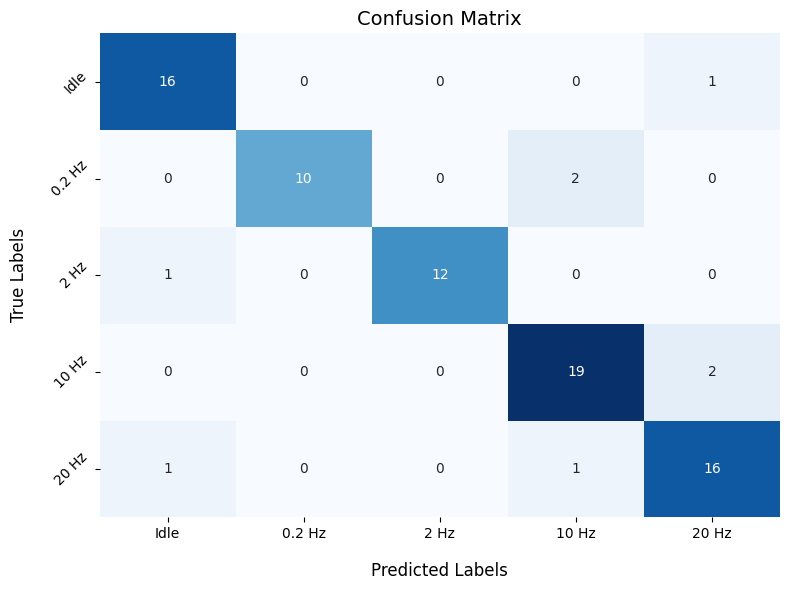

In [3]:
#Set the seed to ensure reproducibility - Was used during the model testing
# set_seed(0)

#Load the data from the CSV's
raw_s = [
    pd.read_csv('idle.csv'),
    pd.read_csv('02.csv'),
    pd.read_csv('2.csv'),
    pd.read_csv('10.csv'),
    pd.read_csv('20.csv'),
]

#Finds the smallest maximum counter across all the CSV's
min_counter = min(max(df['counter']) for df in raw_s)

xdata, ydata = [], []
input_size, resample_step = 52, 20
samples_per_entry = int(min_counter / resample_step)   #How many sequences will be created
features_to_drop = ['time', 'csrmin', 'csrmax', 'csraver', 'esnrmin', 'esnrmax', 'esnraver', 'prefecber']
# features_to_drop = ['time', 'esnrmin', 'esnrmax', 'esnraver', 'prefecber']

#Iterate through the list of DataFrames along with their index
for i, df in enumerate(raw_s):

    #Make Regular Data i.e continuous & Drop unwanted features
    temp = make_regular(df).drop(columns=features_to_drop)

    #Loop through the DataFrame in sequences
    for j in range(samples_per_entry):
        if j * resample_step + input_size > len(temp):   #Check if the sequence would exceed the DataFrame's length
            break
        #Extract Sequence - Takes a slice of length 'input_size' starting at index j * resample_step
        xdata.append(temp[j * resample_step:j * resample_step + input_size].values)
        #Create the labels
        ydata.append(i)

#Convert to NumPy arrays
xdata = np.array(xdata)
ydata = np.array(ydata)


#Split into train 70% + temp (validation 15% + test 15%)
x_train, x_temp, y_train, y_temp = train_test_split(xdata, ydata, test_size=0.3, random_state=42)

#Split temp into validation and test sets
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)


#Convert to PyTorch tensors (with torch.tensor()) &
#Combines the input and labels into a single dataset object (with TensorDataset()) - Each sample in the dataset is a tuple: (sequence, label).
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

#With DataLoader -> split the dataset into batches
train_loader = DataLoader(train_dataset, 16, True)
val_loader = DataLoader(val_dataset, 16, False)
test_loader = DataLoader(test_dataset, 16, False)


#MY MODEL
class CNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=2)
        self.bn3 = nn.BatchNorm1d(256)

        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.3)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)                #Change shape to (batch_size, seq_length, channels)
        x = F.relu(self.bn1(self.conv1(x)))   #Apply conv1 and ReLU
        x = self.dropout1(x)                  #Apply dropout

        x = F.relu(self.bn2(self.conv2(x)))   #Apply conv2 and ReLU
        x = self.dropout2(x)                  #Apply dropout

        x = F.relu(self.bn3(self.conv3(x)))   #Apply conv3 and ReLU
        x = self.dropout3(x)                  #Apply dropout

        x = F.adaptive_max_pool1d(x, 1)       #Max pooling to a fixed length of 1
        x = x.squeeze(-1)                     #Remove the sequence dimension

        return self.fc(x)


#THE TRAINING & THE EVALUATION
device = 'cpu'
input_size = xdata.shape[2]                     #Number of features
num_classes = len(np.unique(ydata))             #Number of labels
model = CNN(input_size, num_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.CrossEntropyLoss()

#Train the model with the help of validation set
best_model = train_network_via_validation(400, optimizer, train_loader, val_loader, loss_fun, model, device)

#Evaluate
print(f"\n=============== Final Evaluation Results ===============\n")
loss, f1, acc, conf = evaluate(test_loader, loss_fun, best_model, device)

print(f"\nTest Loss: {loss:.4f}")
print(f"\nTest Accuracy: {acc*100:.4f}")
print(f"\nF1 Score: {f1*100:.4f}")

#Map class indices to their actual names
class_index_to_name = {
    0: 'Idle',
    1: '0.2 Hz',
    2: '2 Hz',
    3: '10 Hz',
    4: '20 Hz',
}

#Use the mapping to generate the class names
class_names = [class_index_to_name[i] for i in range(num_classes)]
plot_confusion_matrix(conf, class_names)
